In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from PIL import Image
import yaml
from tensorboardX import SummaryWriter
from enum import Enum, unique
from torch.multiprocessing import freeze_support
freeze_support()

class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True

@unique
class Method(Enum):
    PIMP = 0
    LSTM = 1

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:1'

/tmp/ipykernel_843014/1539602785.py:11: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


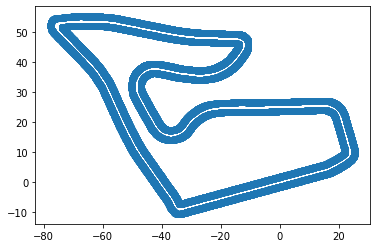

In [3]:
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("../data_generation/track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)

In [4]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

no_race_train_frame = train_frame[train_frame['selected_lane'].apply(lambda x: True if x in ['left', 'center', 'right'] else False)]
no_race_test_frame = test_frame[test_frame['selected_lane'].apply(lambda x: True if x in ['left', 'center', 'right'] else False)]
race_test_frame = full_frame[full_frame['selected_lane'].apply(lambda x: True if x in ['race'] else False)]

RACE_SELECTION = [2246, 2329, 2711, 2596, 2465, 2365, 2805, 2554, 2266]

torch.tensor(np.array(train_frame.iloc[:9]['input_no_curve'].to_list())).shape

torch.Size([9, 10, 3])

In [5]:
class TraceRelativeDataset(Dataset):
    def __init__(self, dataframe, curve=False, vel=True):
        self.dataframe = dataframe
        self.curve = curve

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.curve:
            key = "input"
        else:
            key = "input_no_curve"
        
        try:
            inputs = torch.tensor(np.array(self.dataframe.iloc[idx][key].to_list()), dtype=torch.float32)
            last_pose = torch.tensor(np.array(self.dataframe.iloc[idx]['last_pose'].to_list()), dtype=torch.float32)
            target = torch.tensor(np.array(self.dataframe.iloc[idx]['target'].to_list()), dtype=torch.float32)
        except AttributeError as v:
            inputs = torch.tensor(self.dataframe.iloc[idx][key], dtype=torch.float32)
            last_pose = torch.tensor(self.dataframe.iloc[idx]['last_pose'], dtype=torch.float32)
            target = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.float32)
        return inputs, last_pose, target

train_dataset = TraceRelativeDataset(no_race_train_frame, curve=True)
test_dataset = TraceRelativeDataset(no_race_test_frame, curve=True)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)

print(len(train_dataset), " in train")
print(len(test_dataset), " in test")

1786  in train
447  in test


In [8]:
len(train_dataloader)

56

In [20]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[:,:,:2], target[:,:,:2])
    loss += 4*F.smooth_l1_loss(prediction[:,:,2], target[:,:,2])
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,:,:2]-target[:,:,:2], dim=2)
    ade = torch.mean(loss, dim=0)
    return torch.mean(ade)

def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,-1,:2]-target[:,-1,:2], dim=1)
    return torch.mean(loss)

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, horizon=60, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.horizon = horizon
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            #nn.Linear(hidden_dim//2, hidden_dim//2),
            #nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 3*horizon)
        )
        print("WARNING: 2 layer LSTM + 2 layer decoder")

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = output[:,-1].reshape((inputs.shape[0], self.horizon, 3))
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        residuals =  self.forward(inputs)
        last_poses = last_poses.to(DEVICE)
        outputs = torch.tile(last_poses[:,:3].reshape(last_poses.shape[0],1,3), 
                             (1,60,1))
        outputs = residuals+outputs
        return outputs
        

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, control_outputs=1, num_layers=2):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            #nn.Linear(hidden_dim//2, hidden_dim//2),
            #nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, control_outputs*2+1)
        )
        print("WARNING: 2 layer LSTM + 2 layer decoder")

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:,:,0]))
        for step in range(self.control_outputs):
            scaled_output.append(torch.tanh(output[:,:,(step*2)+1])*np.pi)  # Steering
            scaled_output.append(output[:,:,(step*2)+2])  # Acceleration
        output = torch.dstack(scaled_output)
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        step_length = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = min((i-1)//step_length, self.control_outputs-1)
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,(step*CDIMS)+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,(step*CDIMS)+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace


def create_debug_plot(net, train_dataset:TraceRelativeDataset=train_dataset, test_dataset:TraceRelativeDataset=test_dataset, curvature:Curvature=Curvature.NO_CURVATURE, selection:list=[1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054]):
    if selection is None:
        selection = np.random.choice(len(full_frame), 9)
    inputs, last_poses, targets = train_dataset[:len(selection)]
    inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
    last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
    for i, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        dframe = full_frame
        if curvature is Curvature.NO_CURVATURE:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input_no_curve'], dtype=torch.float32, device=DEVICE)
        else:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input'], dtype=torch.float32, device=DEVICE)
        last_poses[i] = torch.tensor(dframe.loc[DATA_IDX]['last_pose'], dtype=torch.float32, device=DEVICE)
        targets[i] = torch.tensor(dframe.loc[DATA_IDX]['target'], dtype=torch.float32, device=DEVICE)
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()

    fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        dframe = full_frame
        linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input'][:,0], dframe.loc[DATA_IDX]['input'][:,1], marker='.', label="Input")
        ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
        lpred, = axs[idx//3, idx%3].plot(outputs[idx,:,0], outputs[idx,:,1], marker='o', mfc='none', label="Prediction")
        xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
        axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx//3, idx%3].set(xlim=(xlim-3.5,xlim+3.5),
                               ylim=(ylim-3.5,ylim+3.5),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
        axs[idx//3, idx%3].set_title("{}:{}:{}".format("Train" if data_in_train else "Test",DATA_IDX,dframe.loc[DATA_IDX]['selected_lane']))
    fig.suptitle("Manually Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

In [24]:
net = LSTMPredictorBicycle(input_dim=9, hidden_dim=32)
net.to(DEVICE)
#net.load_state_dict(torch.load("best_simple_bicycle.pt"))
for input, last_pose, target in train_dataloader:
    break;
display(input.shape)
display(last_pose.shape)
display(target.shape)
input = input.to(DEVICE)
last_pose = last_pose.to(DEVICE)
other_outp = net.predict(input, last_pose)
other_outp.shape

torch.Size([32, 10, 9])

torch.Size([32, 4])

torch.Size([32, 60, 3])

torch.Size([32, 60, 3])

0.255892276763916

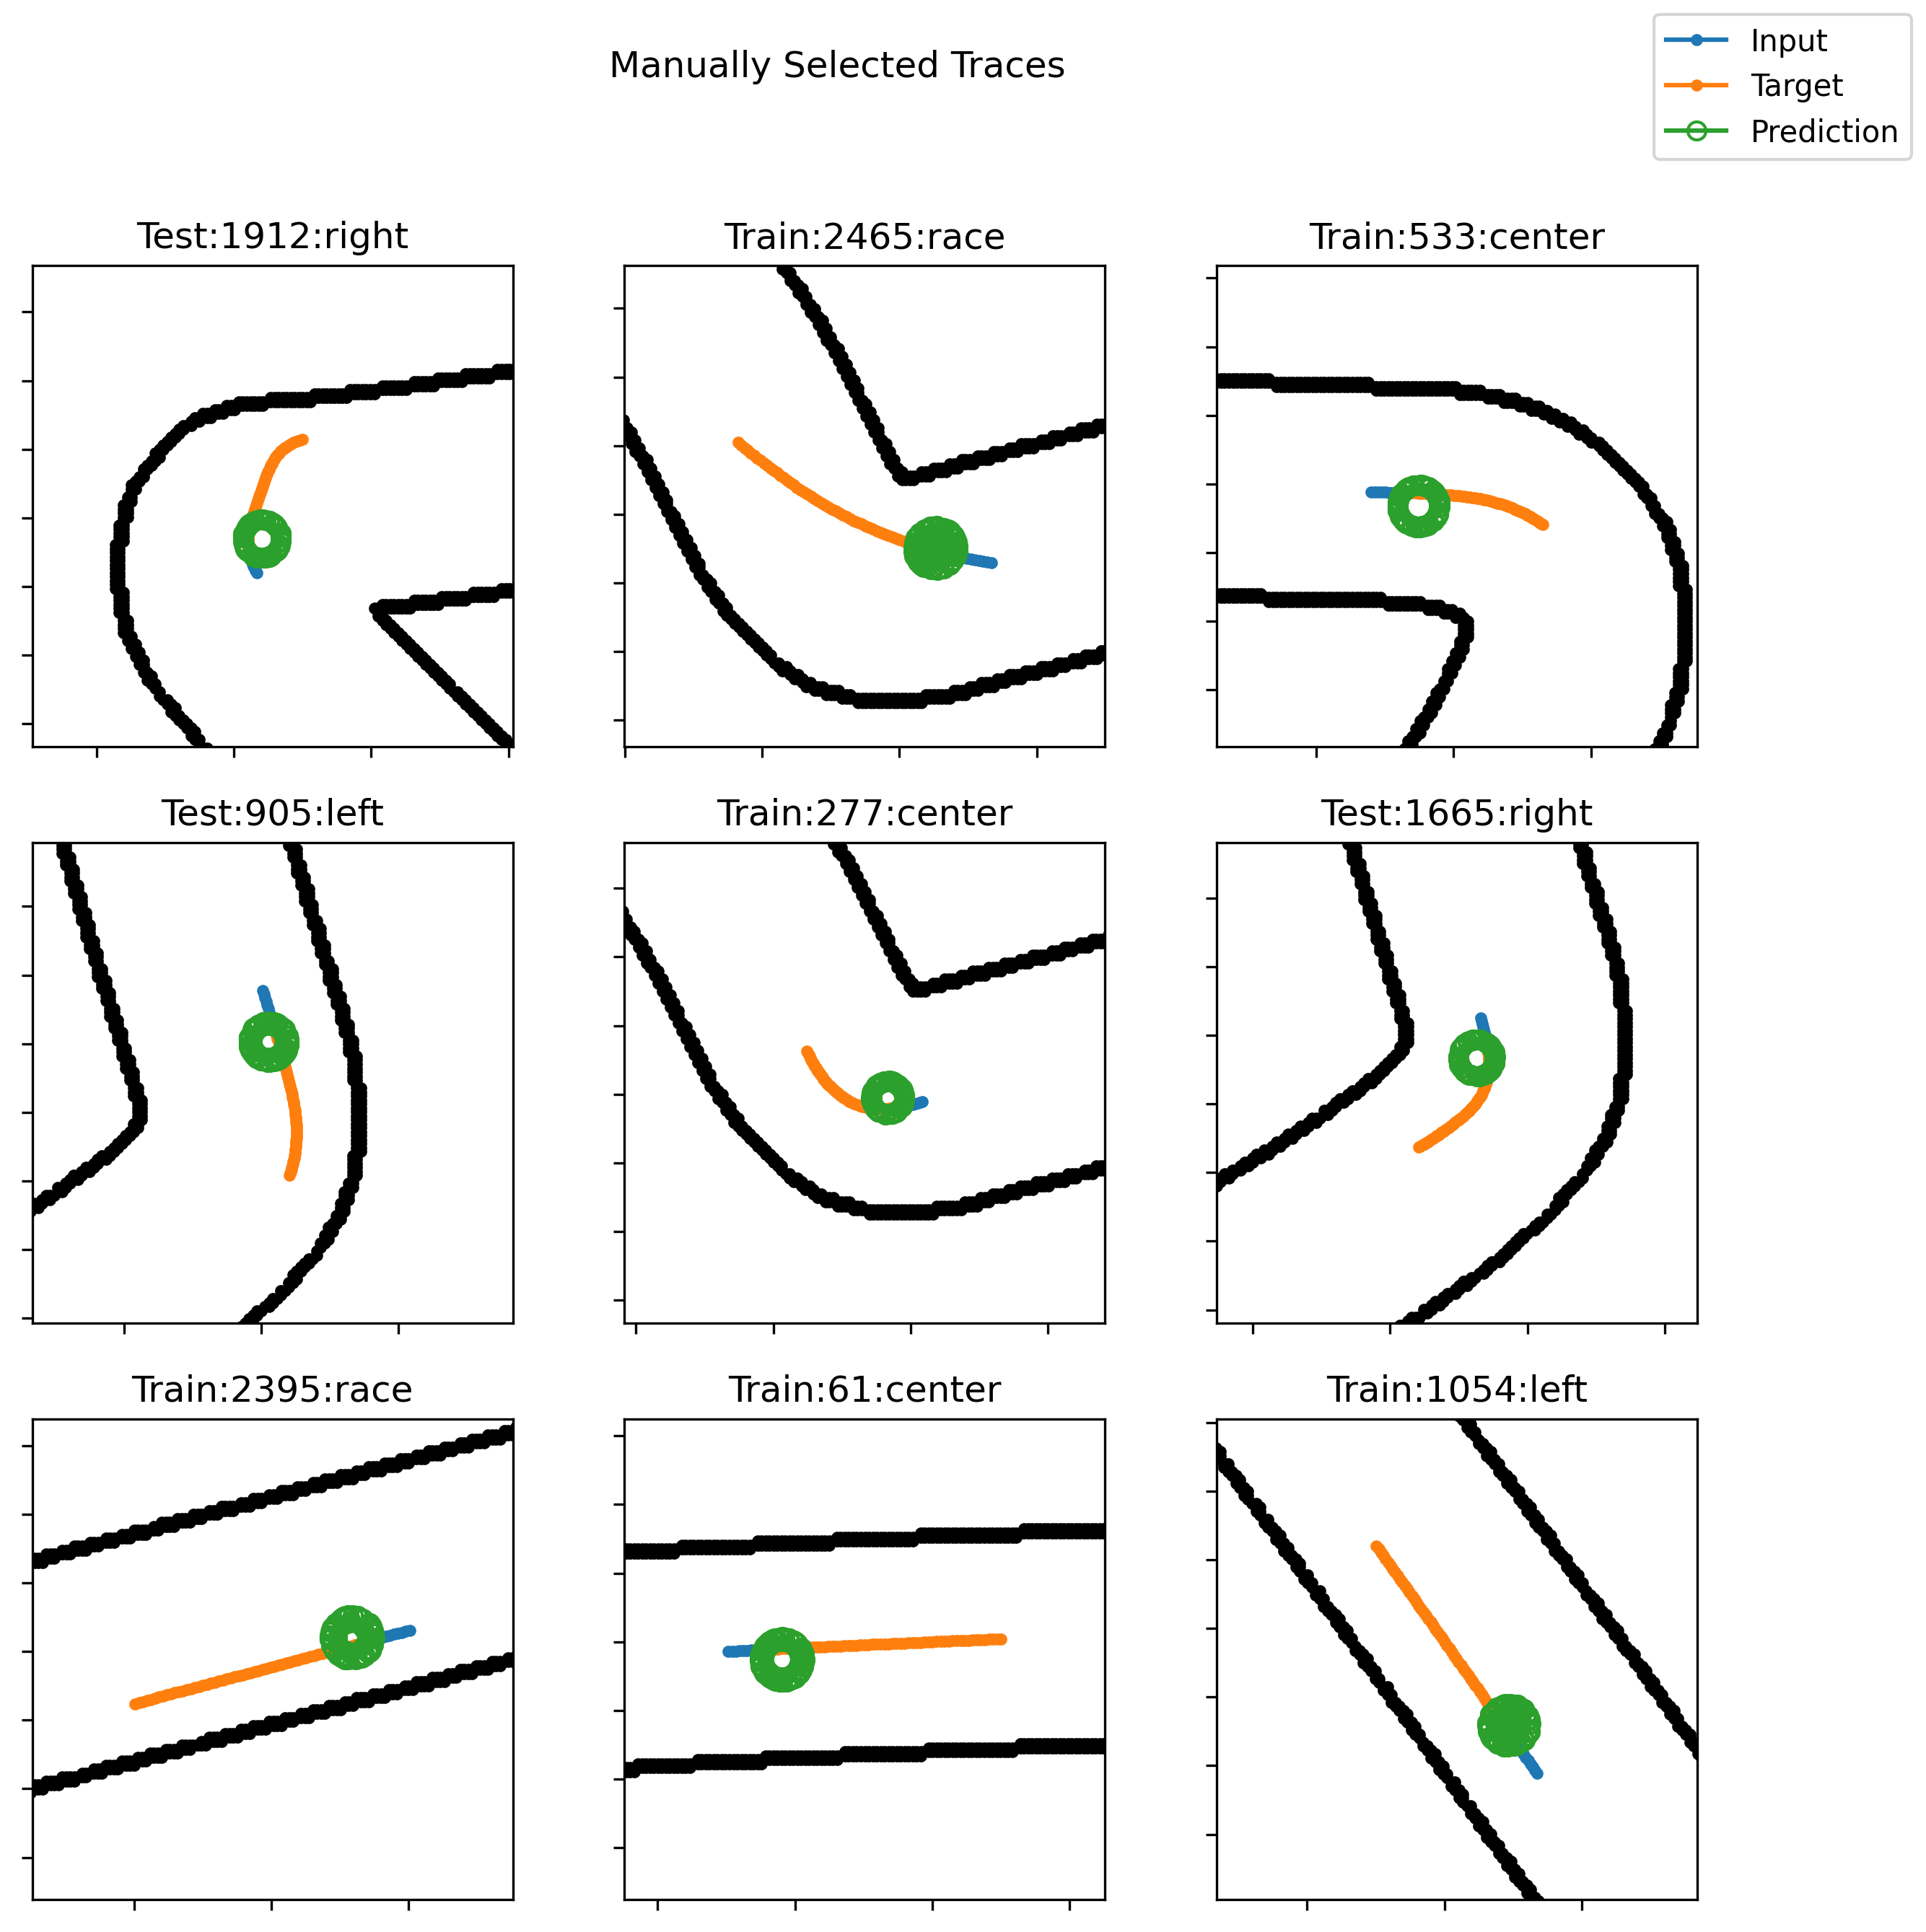

In [25]:
import time
start = time.time()
create_debug_plot(net, curvature=True)
end = time.time()
end-start

In [26]:
net = LSTMPredictor(input_dim=3, hidden_dim=16)
net.to(DEVICE)
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

5348

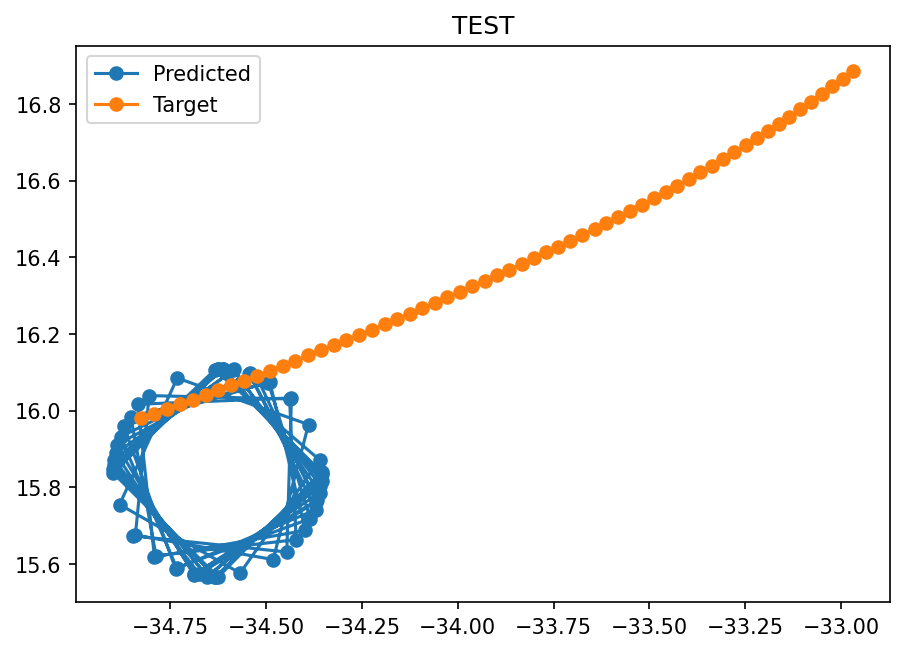

In [27]:
dfig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted');
ax.plot(target[0,:,0].detach().numpy(), target[0,:,1].detach().numpy(), marker='o', label='Target');
ax.legend();

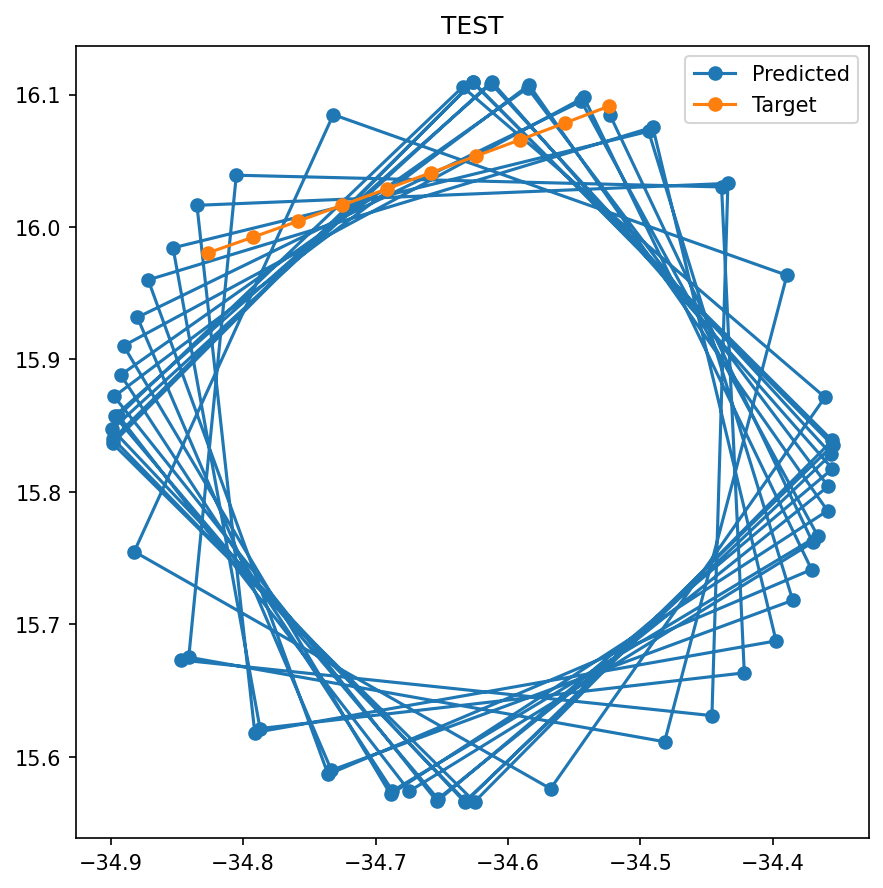

In [28]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150);
ax.set_aspect(1.0, adjustable='box');
ax.set_title("TEST");
ax.plot(other_outp[0,:,0].cpu().detach().numpy(), other_outp[0,:,1].cpu().detach().numpy(), marker='o', label='Predicted')
ax.plot(target[0,:10,0].detach().numpy(), target[0,:10,1].detach().numpy(), marker='o', label='Target')
ax.legend()

In [29]:
loss = nn.MSELoss()
loss(other_outp,torch.tensor(train_frame.iloc[0]['target'], dtype=torch.float32, device=DEVICE))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([60, 3])) that is different to the input size (torch.Size([32, 60, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(2139.3289, device='cuda:1', grad_fn=<MseLossBackward0>)

In [30]:
@unique
class Method(Enum):
    PIMP = 0
    LSTM = 1

def train(method:Method, curvature:Curvature, hidden_dim:int=32, epochs=100, control_outputs=10):
    if method is Method.PIMP:
        directory = f'runs/toy/robustness/{method.name}-{control_outputs}-{curvature.name}-{hidden_dim}/'
    else:
        directory = f'runs/toy/robustness/{method.name}-{curvature.name}-{hidden_dim}/'
    writer = SummaryWriter(directory)

    train_dataset = TraceRelativeDataset(no_race_train_frame, curve=True if curvature is Curvature.CURVATURE else False)
    test_dataset = TraceRelativeDataset(no_race_test_frame, curve=True if curvature is Curvature.CURVATURE else False)
    race_dataset = TraceRelativeDataset(race_test_frame, curve=True if curvature is Curvature.CURVATURE else False)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
    race_dataloader = DataLoader(race_dataset, batch_size=32, shuffle=True, num_workers=4)
    # Training Loop
    torch.autograd.set_detect_anomaly(True)
    if method is Method.PIMP:
        net = LSTMPredictorBicycle(input_dim=9 if curvature is Curvature.CURVATURE else 3,
                                   hidden_dim=hidden_dim,
                                   control_outputs=control_outputs)
    elif method is Method.LSTM:
        net = LSTMPredictor(input_dim=9 if curvature is Curvature.CURVATURE else 3,
                            hidden_dim=hidden_dim)
    net.to(DEVICE)
    pytorch_total_params = sum(p.numel() for p in net.parameters())
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    train_losses = list()
    test_losses = list()
    train_ades, test_ades, race_ades = list(), list(), list()
    train_fdes, test_fdes, race_fdes = list(), list(), list()

    progbar = tqdm(total=epochs, unit='epochs')
    
    for epoch in range(epochs):
        i=0
        
        progbar.set_description("TRAINING")
        cum_train_loss = 0.0
        net.train()
        fde, ade = 0.0, 0.0
        for input_data, last_pose, target_data in train_dataloader:
            net.zero_grad()
            input_data = input_data.to(DEVICE)
            last_pose = last_pose.to(DEVICE)
            outp = net.predict(input_data, last_pose)
            target_data = target_data.to(DEVICE)
            loss = custom_loss_func(outp, target_data)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                fde += final_displacement_error(outp, target_data).cpu().numpy()
                ade += average_displacement_error(outp, target_data).cpu().numpy()
            cum_train_loss += loss.item()

        train_fig, train_ax = create_debug_plot(net, train_dataset, test_dataset, curvature)
        cum_train_loss /= len(train_dataset)
        train_losses.append(cum_train_loss)
        ade, fde = ade/len(train_dataset), fde/len(train_dataset)
        writer.add_scalar("ADE/train", ade, epoch)
        writer.add_scalar("FDE/train", fde, epoch)
        train_ades.append(ade)
        train_fdes.append(fde)
        
        cum_test_loss = 0.0
        fde, ade = 0.0, 0.0
        net.eval()
        progbar.set_description("TESTING")
        with torch.no_grad():
            for input_data, last_pose, target_data in test_dataloader:
                input_data = input_data.to(DEVICE)
                last_pose = last_pose.to(DEVICE)
                outp = net.predict(input_data, last_pose)
                target_data = target_data.to(DEVICE)
                loss = custom_loss_func(outp, target_data)
                cum_test_loss += loss.item()
                fde += final_displacement_error(outp, target_data).cpu().numpy()
                ade += average_displacement_error(outp, target_data).cpu().numpy()
        cum_test_loss /= len(test_dataset)
        test_losses.append(cum_test_loss)
        ade, fde = ade/len(test_dataset), fde/len(test_dataset)
        writer.add_scalar("ADE/test", ade, epoch)
        writer.add_scalar("FDE/test", fde, epoch)
        test_ades.append(ade)
        test_fdes.append(fde)
        
        cum_race_test_loss = 0.0
        fde, ade = 0.0, 0.0
        net.eval()
        progbar.set_description("RACE TESTING")
        with torch.no_grad():
            for input_data, last_pose, target_data in race_dataloader:
                input_data = input_data.to(DEVICE)
                last_pose = last_pose.to(DEVICE)
                outp = net.predict(input_data, last_pose)
                target_data = target_data.to(DEVICE)
                loss = custom_loss_func(outp, target_data)
                cum_test_loss += loss.item()
                fde += final_displacement_error(outp, target_data).cpu().numpy()
                ade += average_displacement_error(outp, target_data).cpu().numpy()
            race_fig, race_ax = create_debug_plot(net, train_dataset, test_dataset, curvature, selection=RACE_SELECTION)
        cum_race_test_loss /= len(race_dataset)
        ade, fde = ade/len(race_dataset), fde/len(race_dataset)
        writer.add_scalar("ADE/race_test", ade, epoch)
        writer.add_scalar("FDE/race_test", fde, epoch)
        race_ades.append(ade)
        race_fdes.append(fde)
        
        if cum_test_loss <= min(test_losses):
            torch.save(net.state_dict(), f"{directory}/best_model.pt")
        writer.add_scalar("loss/train", cum_train_loss, epoch)
        writer.add_scalar("loss/test", cum_test_loss, epoch)
        writer.add_scalar("loss/race", cum_race_test_loss, epoch)
        writer.add_figure("train/example_fig", train_fig, epoch)
        writer.add_figure("race_test/example_fig", race_fig, epoch)
        tqdm.write(f"Epoch {epoch} | Train Loss: {cum_train_loss} | Test Loss: {cum_test_loss}")
        progbar.update()
    
    progbar.close()
    
    return {
        'curvature': curvature,
        'hidden_dims': hidden_dim,
        'training_loss': cum_train_loss,
        'test_loss': cum_test_loss,
        'ade': ade,
        'fde': fde,
        'params': pytorch_total_params
    }

def train_catch(*args, **kwargs):
    import traceback
    try:
        train(*args, **kwargs)
    except Exception as e:
        print("Exception Occurred:")
        print(e)
        traceback.print_exc()
        print("--------------------")

In [31]:
#train(Method.PIMP, Curvature.CURVATURE, 16, 2, 5)

In [38]:
import threading
import torch.multiprocessing as multiprocessing
from torch.multiprocessing import Process, Pool
jobs = [
    (Method.PIMP, Curvature.CURVATURE, 16, 200, 10),
    (Method.PIMP, Curvature.CURVATURE, 8, 200, 10),
    (Method.PIMP, Curvature.CURVATURE, 16, 200, 5),
    (Method.PIMP, Curvature.CURVATURE, 8, 200, 5),
    (Method.LSTM, Curvature.CURVATURE, 16, 200),
    (Method.LSTM, Curvature.CURVATURE, 8, 200),
]

In [39]:
for j in jobs:
    print(j)

(<Method.PIMP: 0>, <Curvature.CURVATURE: True>, 16, 200, 10)
(<Method.PIMP: 0>, <Curvature.CURVATURE: True>, 8, 200, 10)
(<Method.PIMP: 0>, <Curvature.CURVATURE: True>, 16, 200, 5)
(<Method.PIMP: 0>, <Curvature.CURVATURE: True>, 8, 200, 5)
(<Method.LSTM: 1>, <Curvature.CURVATURE: True>, 16, 200)
(<Method.LSTM: 1>, <Curvature.CURVATURE: True>, 8, 200)


In [40]:
with multiprocessing.get_context('spawn').Pool(processes=5) as pool:
    res = pool.starmap(train, jobs)

Process SpawnPoolWorker-9625:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'train' on <module '__main__' (built-in)>
Process SpawnPoolWorker-9624:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 358, in get
  

KeyboardInterrupt: 

In [ ]:
net = LSTMPredictor(input_dim=3, hidden_dim=64, horizon=60)

In [ ]:
sum(p.numel() for p in net.parameters())